In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
np.random.seed(1231)

In [3]:
df = pd.read_excel("data/nph_3069_sm_tables2.xls", sheet_name="Sheet1",
                   header=5, skipfooter=5, usecols="A:B,D:P,R:AC") \
    .fillna(0) \
    .drop(0)   \
    .rename(columns={"Unnamed: 0": "Tree", "Unnamed: 1": "Cohort"})
df = df.astype({k: int for k in df.columns[2:]})
df["Tree"] = df["Tree"].replace("a|b", "", regex=True).astype(int)
df

Tree Cohort  VES-01  VES-02  VES-03  VES-04  VES-05  VES-06  VES-07  \
1     37      1       0       0       0       0       0       0       0   
2     38      1       0       0       0       0       0       0       0   
3     39      1       0       0       0       0       0       0       0   
4     40      1       0       0       0       0       0       0       0   
5     42      1       0       0       0       0       0       0       0   
..   ...    ...     ...     ...     ...     ...     ...     ...     ...   
74    64      4       3       0       0       0       0       0       0   
75    83      4       0       1       0       0       0      11       3   
76    85      4       0       0       1       0       0       1       0   
77    86      4       3       0       0       0       0       2       0   
78    90      4       0       1       0       0       0       0       1   

    VES-08  ...  VIN-03  VIN-04  VIN-05  VIN-06  VIN-07  VIN-08  VIN-09  \
1        0  ...       0       0       0       0       0       0       0   
2        0  ...       0       0       0       0       0       0       0   
3        0  ...       0       0       0       0       0       0       0   
4        0  ...       1       0       0       0       0       0       0   
5        0  ...       0       0       0       0       0       0       0   
..     ...  ...     ...     ...     ...     ...     ...     ...     ...   
74       0  ...       0       0       0       0       0       0       0   
75       0  ...       2       0       0       0       0       0       0   
76       0  ...       0       0       1       0       0       0       0   
77       0  ...       0       0       0       0       0       0       0   
78       0  ...       0       0       1       0       0       0       0   

    VIN-10  VIN-11  VIN-12  
1        0       0       0  
2        0       0       0  
3        0       0       0  
4        0       0       0  
5        0       0       0  
..     ...     ...     ...  
74       0       0       0  
75       0       0       0  
76       0       0       0  
77       0       0       0  
78       0       0       0  

[78 rows x 27 columns]

In [4]:
#Initialize graph
B = nx.Graph()

# add genets nodes
B.add_nodes_from(df.columns[2:], bipartite=0)

#Cohort-diameter map
cohort_diameter_map = {1: (0.7, 0.68), 2: (8.1, 5.2), 3: (24.5, 6.2), 4: (46.4, 5.3)}

def calc_carbon(diameter, max_diameter, stress_level=0):
    fraction = diameter/max_diameter
    carbon = np.tanh((fraction - 0.5)*np.pi*2) + stress_level
    return carbon
    
# add tree nodes
for _, row in df.iterrows():
    mean, stdev = cohort_diameter_map[row["Cohort"]]
    B.add_node(row["Tree"], bipartite=1, cohort=row["Cohort"], diameter=np.random.normal(mean, stdev))

max_diameter = max(nx.get_node_attributes(B, "diameter").values())    

for node in B.nodes():
    if (B.nodes[node]["bipartite"] == 1):
        B.nodes[node]["carbon_value"] = calc_carbon(B.nodes[node]["diameter"], max_diameter)

edges = []
# add edges between genets and trees
for _, row in df.iterrows():
    for genet, n in row[2:].items():
        if n > 0:
            edges.append((genet, row["Tree"]))
            

            
B.add_edges_from(edges)
B.remove_nodes_from([x for x in B.nodes() if B.degree(x) == 0])
B.remove_nodes_from(("VES-11", 79)) # disconnected part

Trees: 55, genets: 24


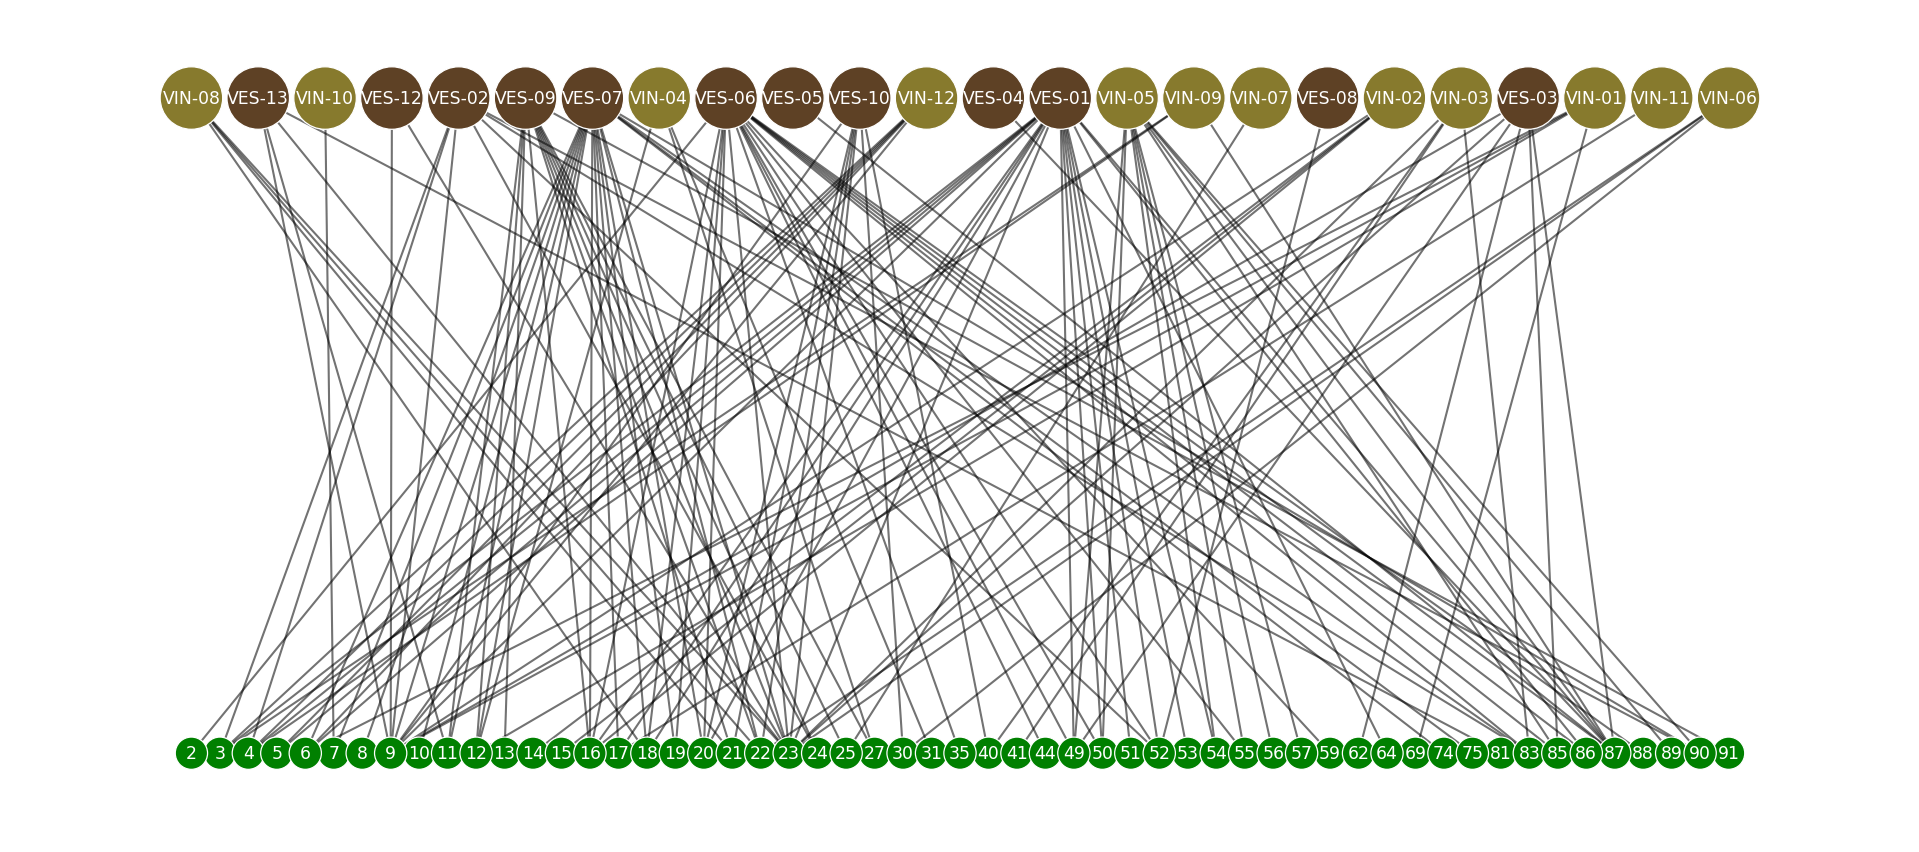

In [5]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

Avg. degree: 19.490909090909092; Max degree: 47 (tree 23)


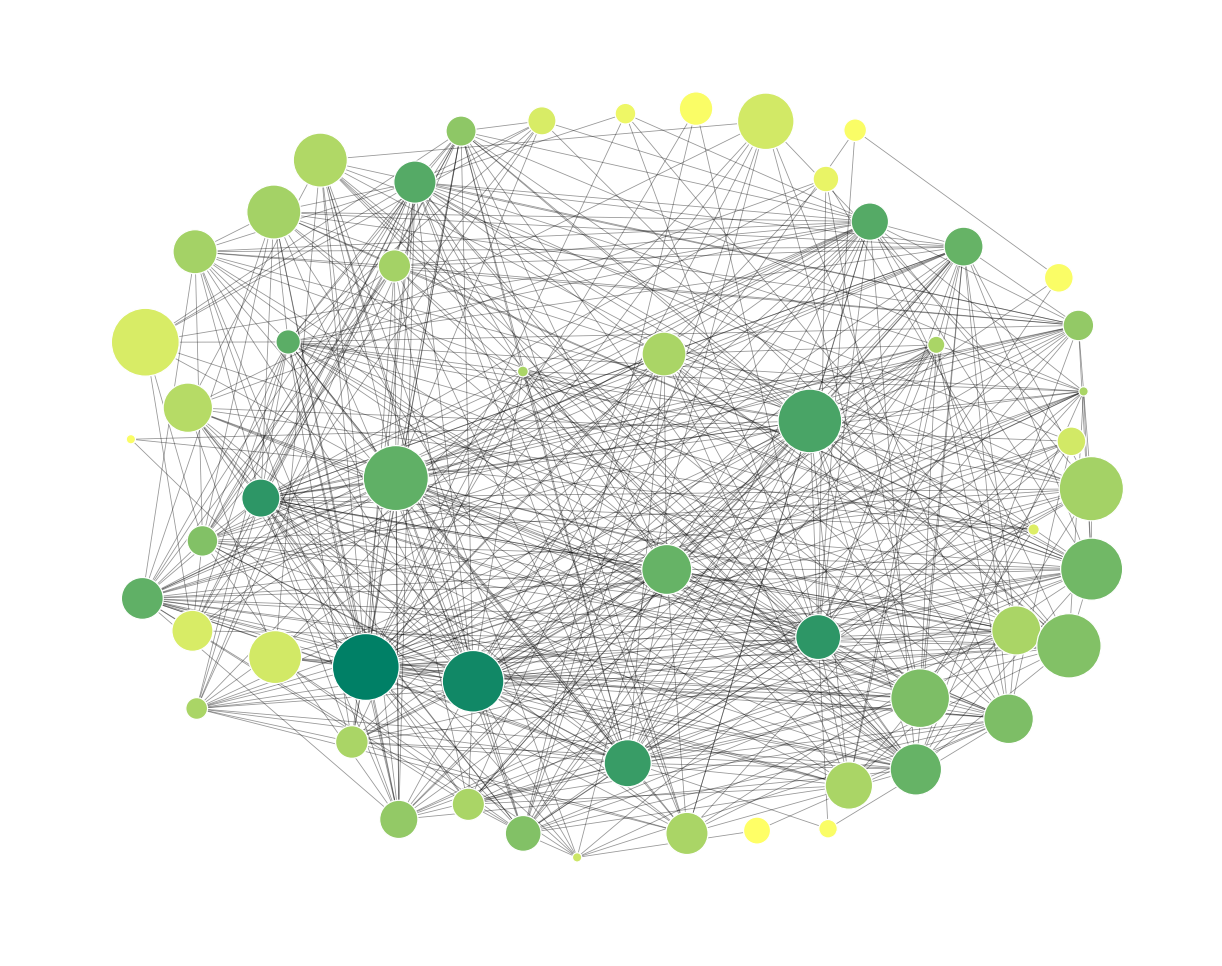

In [15]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)
print(f"Avg. degree: {np.average(degrees)}; Max degree: {np.max(degrees)} (tree {sorted_degrees[-1]})")
# print(nx.get_edge_attributes(G, "weight"))

pos = nx.spring_layout(G, k=3,seed=99192, weight=None)

node_sizes = []

for node in G.nodes:
    node_size = max(5, G.nodes[node]["diameter"]*5)
    node_sizes.append(node_size)

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=degrees,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.summer_r)
#nx.draw_networkx_labels(G, pos, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

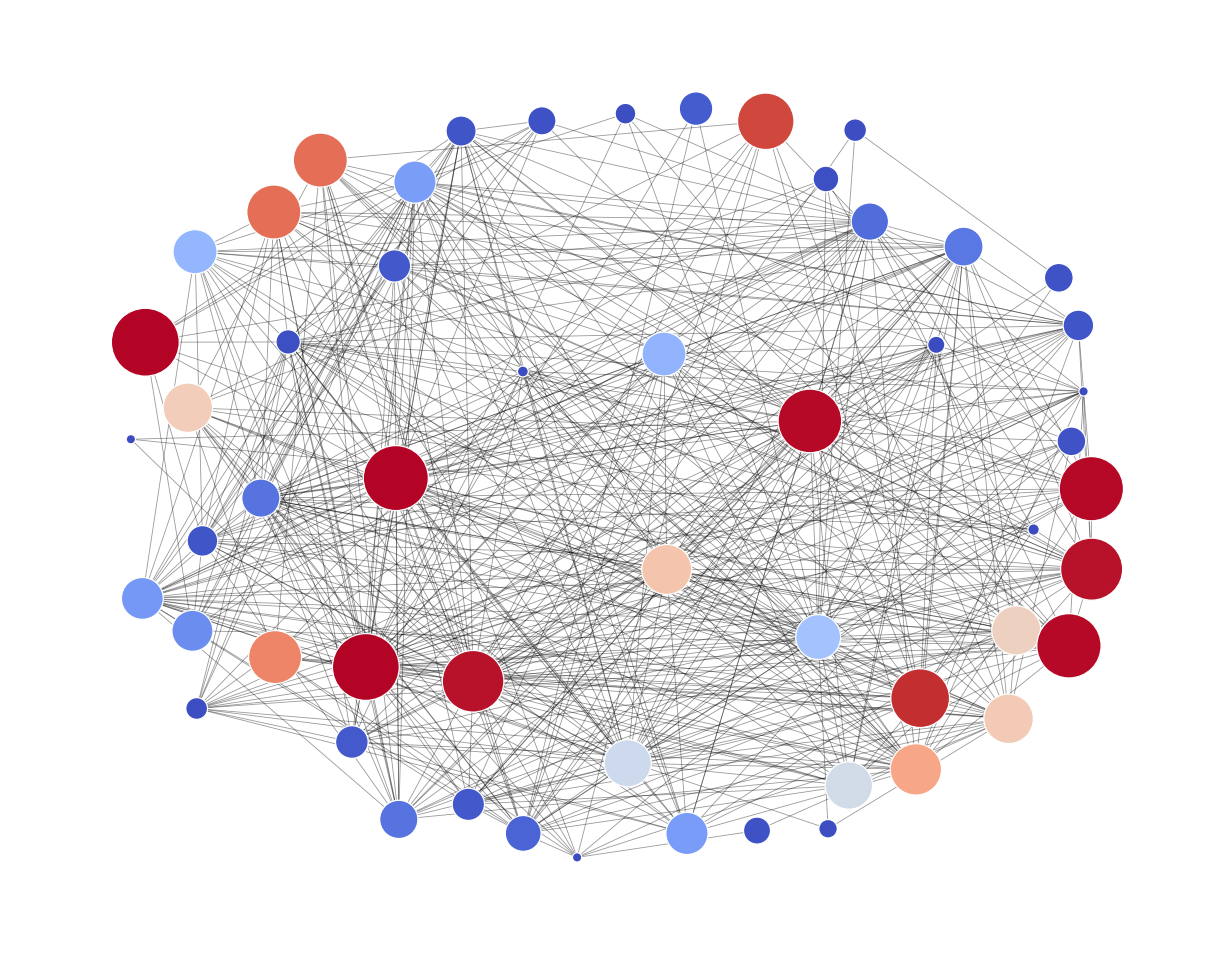

In [48]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
carbon_values = list(nx.get_node_attributes(G, "carbon_value").values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_values,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.coolwarm)
#nx.draw_networkx_labels(G, pos, labels = carbon_values, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

In [162]:
G.nodes

NodeView((2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 31, 35, 40, 41, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 62, 64, 69, 74, 75, 81, 83, 85, 86, 87, 88, 89, 90, 91))

In [248]:
def diffusion_dynamics(t, y, G, D_C, D_h, c3, N):
    carbon, hormone = y[:N], y[N:] # y has to be 1-dimensional :(
    carbon_next, hormone_next = np.zeros(len(carbon)), np.zeros(len(hormone))
    
    for i in range(N):
        node_idx = list(G.nodes)[i]
        node = G.nodes[node_idx]
        neighbors = G.neighbors(node_idx)
        
        for j in neighbors:
            neighbor_node_idx = list(G.nodes).index(j)
            
            neighbor_carbon = carbon[neighbor_node_idx]
            neighbor_hormone = hormone[neighbor_node_idx]
            
            carbon_next[i] += D_C*(neighbor_carbon - carbon[i]) - c3*carbon[i]**2*hormone[i]
            hormone_next[i] += D_h*(neighbor_hormone - hormone[i]) + c3*carbon[i]**2*hormone[i]
        
    return np.concatenate((carbon_next, hormone_next))

In [264]:
from scipy.integrate import solve_ivp

init_carbon = list(nx.get_node_attributes(G, "carbon_value").values())

init_hormone = np.array(init_carbon)
init_hormone = -init_hormone
init_hormone[np.where(init_hormone < 0)] = 0

N = len(G.nodes)
t_range = (0, 2)
D_C = 0.2 # carbon diffusion coeff
D_h = 0.8 # hormone diffusion coeff
c3 = 0.01
sol = solve_ivp(diffusion_dynamics, t_range, init_carbon + init_hormone.tolist(), args=(G, D_C, D_h, c3, N),
                dense_output=True)

In [265]:
time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

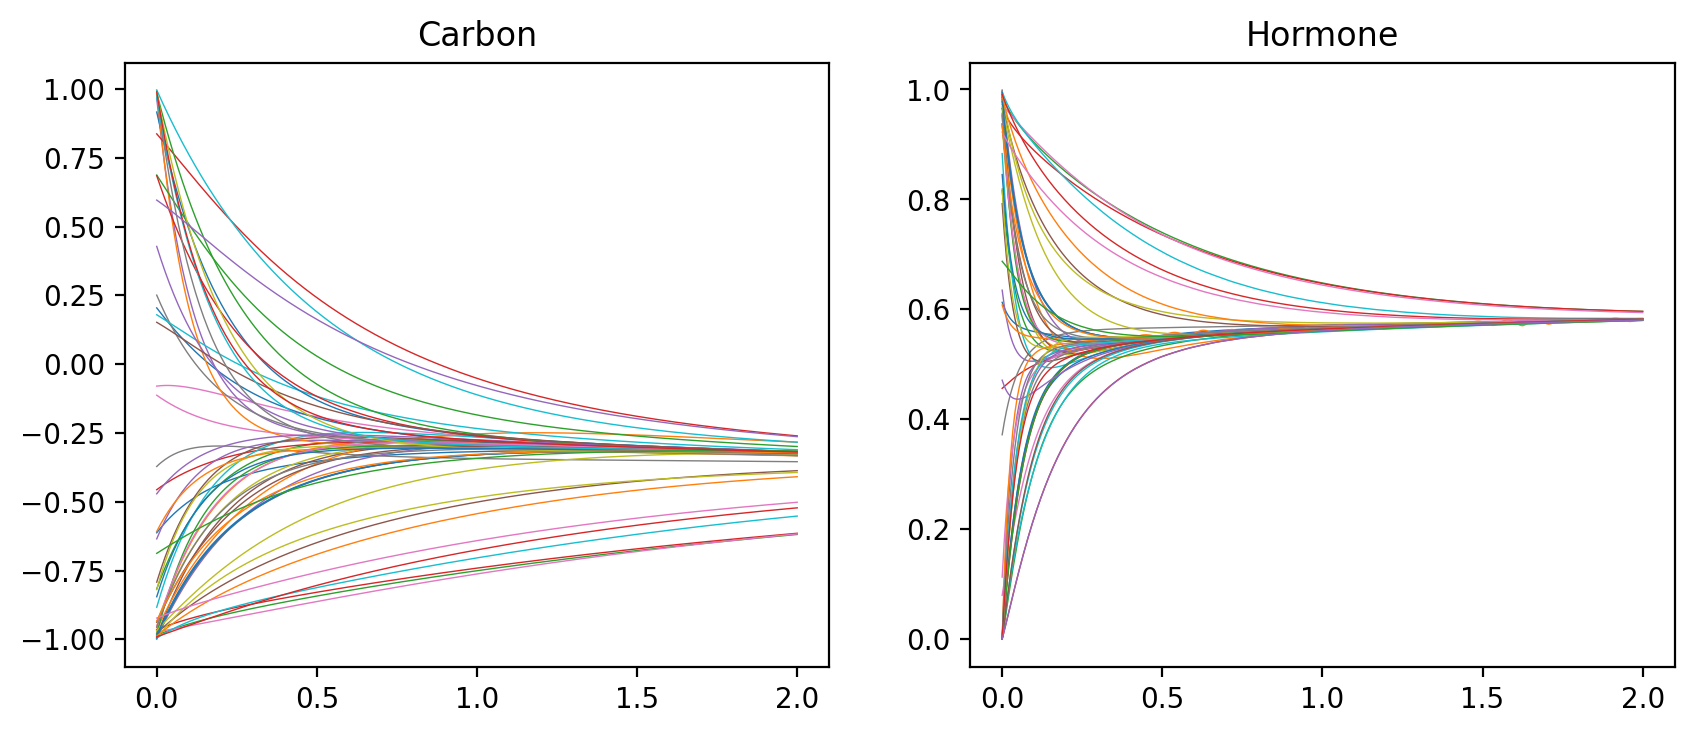

In [266]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

axes[0].set_title("Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    
axes[1].set_title("Hormone")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)

plt.show()

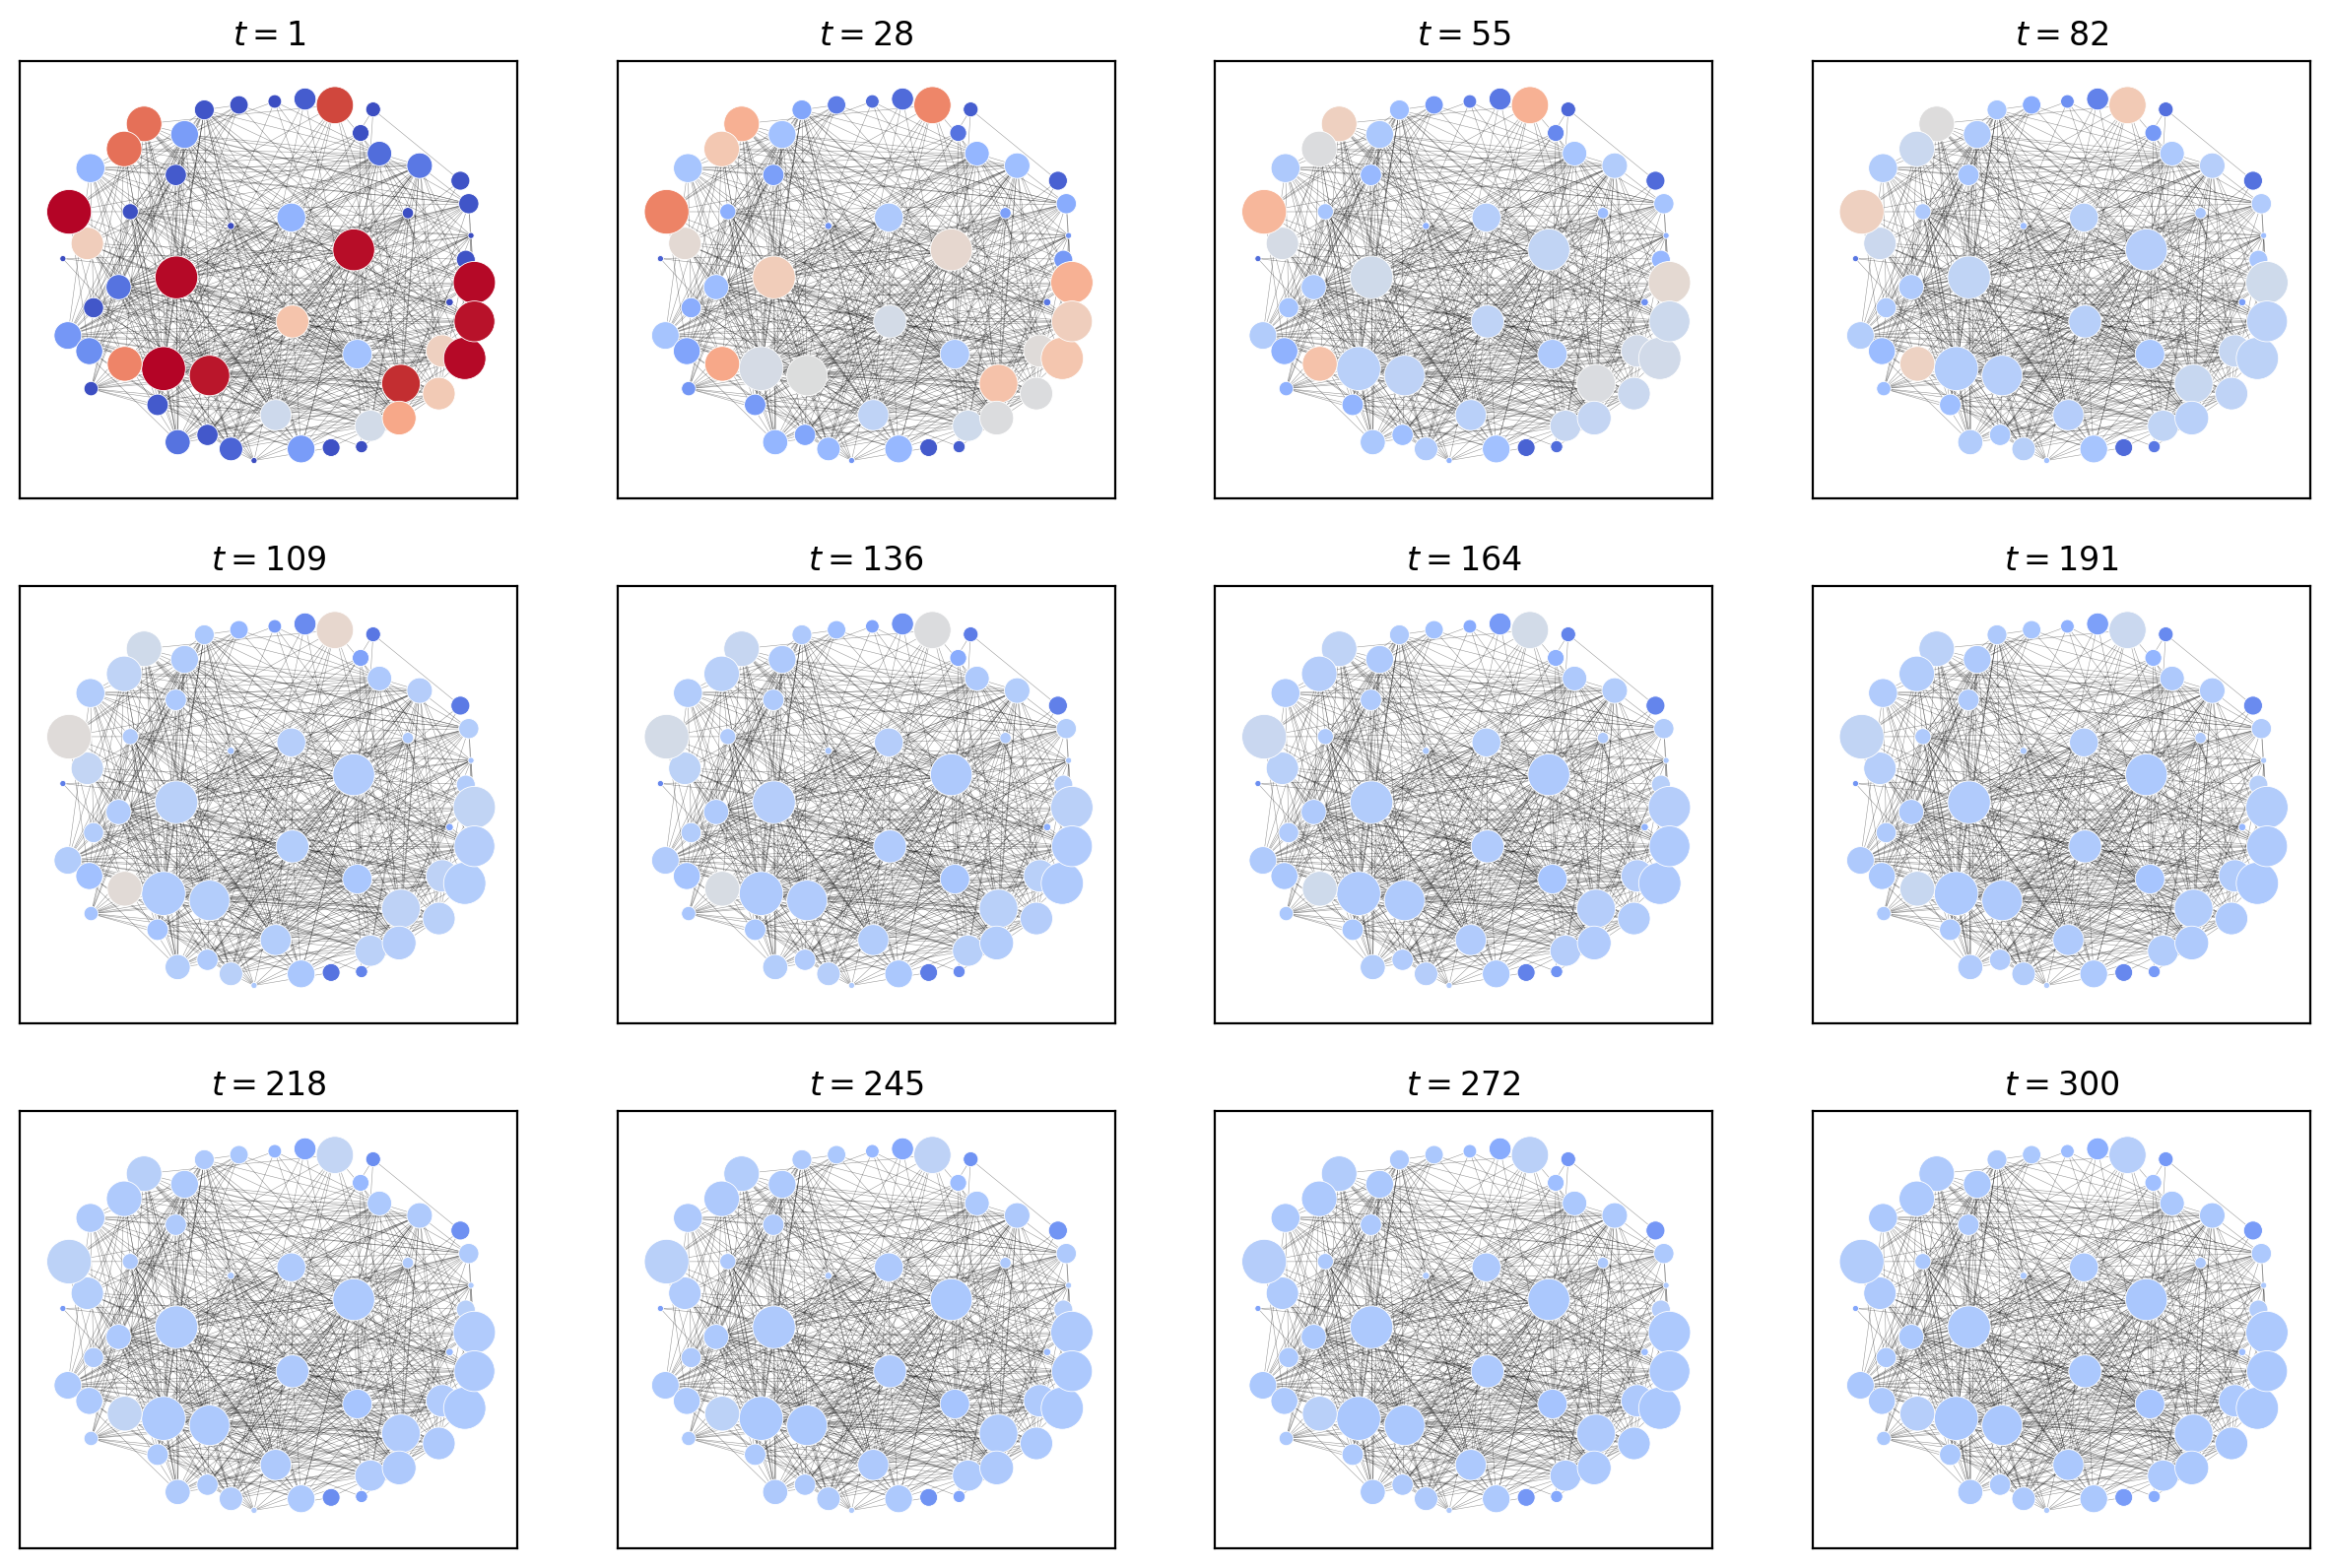

In [267]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), dpi=200)

steps = np.linspace(0, time_steps-1, 12, dtype=int)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {steps[j] + 1}$")
    carbon_vals_t = z[:,steps[j]][:N]
    hormone_vals_t = z[:,steps[j]][N:]
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_vals_t,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=-1, vmax=1)
    #nx.draw_networkx_labels(G, pos, labels = carbon_values, font_color="black", font_size=4.1)
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
    
plt.show()

/tmp/ipykernel_3180375/2609373657.py:6: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


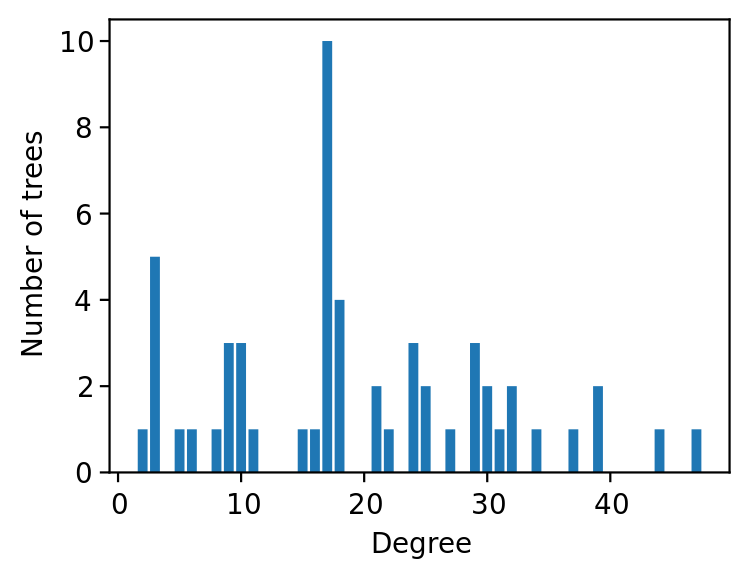

In [206]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot()
ax.bar(*np.unique(sorted(degrees, reverse=True), return_counts=True))
ax.set_xlabel("Degree")
ax.set_ylabel("Number of trees")
plt.show()